In [1]:
!pip install googledrivedownloader

In [ ]:
!pip install openpyxl

In [ ]:
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import RandomizedSearchCV, cross_validate
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
from xgboost import XGBClassifier, XGBRegressor

import seaborn as sns
import scipy.stats as st

from google_drive_downloader import GoogleDriveDownloader as gdd
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#changable parameters
target = "Class Label(GDM /Non GDM)"
test_size = 0.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#import dataset from google drive
"""gdd.download_file_from_google_drive(file_id=data_url.split('id=')[1][:21],
                                    dest_path='/content/drive/MyDrive/Projects/gestational diabetes/data.xlsx',
                                    unzip=True)"""

"gdd.download_file_from_google_drive(file_id=data_url.split('id=')[1][:21],\n                                    dest_path='/content/drive/MyDrive/Projects/gestational diabetes/data.xlsx',\n                                    unzip=True)"

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/Projects/gestational diabetes/data.xlsx",engine='openpyxl')
df.fillna(method="ffill", inplace=True,axis=0)
df.drop(['Case Number','BMI', 'OGTT'],inplace=True, axis=1)
df.reset_index(inplace=True)
df.head()

,index,Age,No of Pregnancy,Gestation in previous Pregnancy,HDL,Family History,unexplained prenetal loss,Large Child or Birth Default,PCOS,Sys BP,Dia BP,Hemoglobin,Sedentary Lifestyle,Prediabetes,Class Label(GDM /Non GDM)
0,0,22,2,1,55.0,0,0,0,0,102.0,69,12.0,0,0,0
1,1,26,2,1,53.0,0,0,0,0,101.0,63,12.4,0,0,0
2,2,29,1,0,50.0,0,0,0,0,118.0,79,14.3,0,0,0
3,3,28,2,1,51.0,0,0,0,0,99.0,70,15.0,0,0,0
4,4,21,2,1,52.0,0,0,0,0,116.0,65,15.0,0,0,0


In [ ]:
len(df)

3525

In [ ]:
#classification or regression
if (type(df[target][0]) == str) or (type(df[target][0]) == int) or (type(df[target][0]) == np.int16) or (type(df[target][0]) == np.int32) or (type(df[target][0]) == np.int64):
    models_type = 'classification'
else:
    models_type = 'regression'


print(models_type)

classification


In [ ]:
def label_encoding(old_column):
    le = LabelEncoder()
    le.fit(old_column)
    new_column = le.transform(old_column)
    return new_column

In [ ]:
#encoding string parameters
for i in df.columns:
    if type(df[i][0]) == str:
        df[i] = label_encoding(df[i])

In [ ]:
#extracting x and y
y = df[target].values

x = df.drop([target], axis=1).values

In [ ]:
#spliting  data
X_train, X_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=test_size)

In [ ]:
#ensemble models for classification

if models_type == 'classification':

    model_1 = RandomForestClassifier()

    k_fold_cv = 5
    params = {
     "n_estimators" : [10,50,100],
     "max_features" : ["auto", "log2", "sqrt"],
     "bootstrap" : [True, False]
     }
    clf1 = RandomizedSearchCV(model_1, param_distributions=params, cv=k_fold_cv,
     n_iter = 5, scoring="accuracy",verbose=2, random_state=42,
     n_jobs=-1, return_train_score=True)
    clf1.fit(X_train, y_train)



    #######################################


    model_2 = XGBClassifier(eval_metric='mlogloss')

    params = {
                "n_estimators": st.randint(3, 40),
                "max_depth": st.randint(3, 40),
                "learning_rate": st.uniform(0.05, 0.4),
                "colsample_bytree": st.beta(10, 1),
                "subsample": st.beta(10, 1),
                "gamma": st.uniform(0, 10),
                'objective': ['binary:logistic'],
                'scale_pos_weight': st.randint(0, 2),
                "min_child_weight": st.expon(0, 50),

            }

    # Random Search Training with 5 folds Cross Validation
    clf2 = RandomizedSearchCV(model_2, params, cv=5,
                             n_jobs=1, n_iter=100)

    clf2.fit(X_train, y_train)



    #######################################


    model_3 = LogisticRegression(max_iter=160)
    model_3.fit(X_train,y_train)

    params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }


    clf3 = RandomizedSearchCV(model_3, params, cv=5,
                             n_jobs=1, n_iter=100)

    clf3.fit(X_train, y_train)



    #######################################



    model_4 = KNeighborsClassifier()
    model_4.fit(X_train,y_train)

    param_grid=dict(n_neighbors=list(range(1,31)))
    print(param_grid)

    clf4 = RandomizedSearchCV(model_4, param_grid, cv=10, scoring='accuracy')
    clf4.fit(X_train, y_train)



    #######################################



    train_results = np.array([clf1.predict(X_train),
                        clf2.predict(X_train),
                        clf3.predict(X_train),
                        clf4.predict(X_train)]).T



    final_model = XGBClassifier()

    final_model = final_model.fit(train_results, y_train)

    test_results = np.array([clf1.predict(X_test),
                        clf2.predict(X_test),
                        clf3.predict(X_test),
                        clf4.predict(X_test)]).T


    pred_final = final_model.predict(test_results)

    print("accuracy is: ",accuracy_score(y_test, pred_final))


    #######################################

    #save models

    filename = 'clf1.sav'
    pickle.dump(clf1, open(filename, 'wb'))

    filename = 'clf2.sav'
    pickle.dump(clf2, open(filename, 'wb'))

    filename = 'clf3.sav'
    pickle.dump(clf3, open(filename, 'wb'))

    filename = 'clf4.sav'
    pickle.dump(clf4, open(filename, 'wb'))

    filename = 'final_model.sav'
    pickle.dump(final_model, open(filename, 'wb'))


Fitting 5 folds for each of 5 candidates, totalling 25 fits
{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]}
accuracy is:  0.9787234042553191


In [ ]:
#ensemble models for regression

if models_type == 'regression':

    model_1 = RandomForestRegressor()

    k_fold_cv = 5
    params = {
     "n_estimators" : [10,50,100],
     "max_features" : ["auto", "log2", "sqrt"],
     "bootstrap" : [True, False]
     }
    clf1 = RandomizedSearchCV(model_1, param_distributions=params, cv=k_fold_cv,
     n_iter = 5, scoring="neg_mean_squared_error",verbose=2, random_state=42,
     n_jobs=-1, return_train_score=True)
    clf1.fit(X_train, y_train)



    #######################################


    model_2 = XGBRegressor()

    params = {
                "n_estimators": st.randint(3, 40),
                "max_depth": st.randint(3, 40),
                "learning_rate": st.uniform(0.05, 0.4),
                "colsample_bytree": st.beta(10, 1),
                "subsample": st.beta(10, 1),
                "gamma": st.uniform(0, 10),
                'scale_pos_weight': st.randint(0, 2),
                "min_child_weight": st.expon(0, 50),

            }

    # Random Search Training with 5 folds Cross Validation
    clf2 = RandomizedSearchCV(model_2, params, cv=5,
                             n_jobs=1, n_iter=100)

    clf2.fit(X_train, y_train)



    #######################################


    clf3 = LinearRegression()

    clf3.fit(X_train,y_train)





    #######################################



    model_4 = KNeighborsRegressor()
    model_4.fit(X_train,y_train)

    param_grid=dict(n_neighbors=list(range(1,31)))

    clf4 = RandomizedSearchCV(model_4, param_grid, cv=10, scoring='accuracy')
    clf4.fit(X_train, y_train)



    #######################################



    train_results = np.array([clf1.predict(X_train),
                        clf2.predict(X_train),
                        clf3.predict(X_train),
                        clf4.predict(X_train)]).T



    final_model = XGBRegressor()

    final_model = final_model.fit(train_results, y_train)

    test_results = np.array([clf1.predict(X_test),
                        clf2.predict(X_test),
                        clf3.predict(X_test),
                        clf4.predict(X_test)]).T


    pred_final = final_model.predict(test_results)

    print("socre is: ",mean_squared_error(y_test, pred_final))


    #######################################

    #save models

    filename = 'clf1.sav'
    pickle.dump(clf1, open(filename, 'wb'))

    filename = 'clf2.sav'
    pickle.dump(clf2, open(filename, 'wb'))

    filename = 'clf3.sav'
    pickle.dump(clf3, open(filename, 'wb'))

    filename = 'clf4.sav'
    pickle.dump(clf4, open(filename, 'wb'))

    filename = 'final_model.sav'
    pickle.dump(final_model, open(filename, 'wb'))


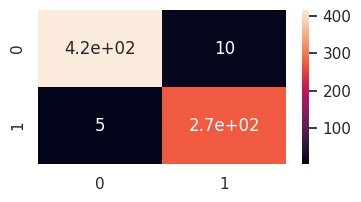

In [ ]:
#confusion matrix plot
if models_type == 'classification':
    cm = confusion_matrix(y_test, pred_final)
    sns.set(rc={"figure.figsize":(4, 2)})
    sns.heatmap(cm, annot=True)